<p style="font-family: helvetica,arial,sans-serif; font-size:2.0em;color:white; background-color: black">&emsp;<b>Green Walls</b></p>
    
<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:black; background-color: #DDDDDD; text-align:justify">&emsp;<b>Authored by: </b> Ryan Waites, ___, ___</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black; text-align:right"><b>Duration:</b> 90 mins&emsp;</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:black; background-color: #DDDDDD; text-align:justify">&emsp;<b>Level: </b>Beginner &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<b>Pre-requisite Skills:</b>Python</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black">&emsp;<b>Scenario</b>

#### As a city planner, I want to determine the best potential locations for new green walls in the city of Melbourne. What locations would be most beneficial?

#### I would like to visualise factors such as pollution, temperatures and tree coverage.

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black">&emsp;<b>What this Use Case will teach you</b>

At the end of this use case you will:
- understand how to access and collect data from Melbourne Open Data
- have explored datasets including Microclimate Sensor Readings & Locations, and Tree Canopies.
- have combined and visualised multiple datasets over a map of the city.

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black">&emsp;<b>A brief introduction to the datasets used</b>

### Issue being addressed

One of the many priorities of the City of Melbourne is the environment and climate moving forward as outlined in the councils [visions and goals](https://www.melbourne.vic.gov.au/about-council/vision-goals/Pages/climate-biodiversity-emergency.aspx). Green walls provide another option to assist in meeting several of these goals alongside the other solutions planned or in progress. Several considerations, requirements and benefits associated with the inclusion of green walls can be explored further in the [growing green guide](https://www.melbourne.vic.gov.au/SiteCollectionDocuments/growing-green-guide.pdf). As such we want to explore datasets that can provide insight into specific locations throughout the city where green walls can have a significant impact.

### Datasets overview

The City of Melbourne offers access to the data obtained from its Microclimate Sensors placed that have been placed in several locations around in the city. For this use case, we will access this information from the [Microclimate Sensor Readings](https://data.melbourne.vic.gov.au/Environment/Microclimate-Sensor-Readings/u4vh-84j8) and its paired dataset [Microclimate Sensor Locations](https://data.melbourne.vic.gov.au/Environment/Microclimate-Sensor-Locations/irqv-hjr4) which we'll use to identify each sensors location and current status.

We'll be focusing on the Particulate Matter 10 (PM10) and temperature readings in particular, as a significant benefit of the installation of green walls is a potential reduction in these areas as well as the general increase in sustainability and overall health.

[insert additional datasets used]

Finally we will be using the [Tree Canopies 2021 (Urban Forest)](https://data.melbourne.vic.gov.au/Environment/Tree-Canopies-2021-Urban-Forest-/krg7-hmyt) to get an overview of the existing tree cover throughout the city which we'll also visualise on our map.

### Package/Library Imports
To begin we will import the required libraries to perform our exploratory analysis and visualisation of the datasets.

The following are core packages required for this exercise:
- The sodapy package is required for accessing open data from SOCRATA compliant open data websites.
- The matplotlib.pyplot is required for the graphs used to visualise our data.
- The branca.colormap is required to provide a colormap for use in mapping visualisations.
- The folium package is required for the mapping visualisations

In [1]:
import os

import numpy as np
import pandas as pd
from datetime import datetime
from sodapy import Socrata
import matplotlib.pyplot as plt
import branca.colormap as cm
import folium
from folium.plugins import MarkerCluster

In [2]:
dataset_id = 'u4vh-84j8' # Melbourne Microclimate Sensor Readings

apptoken = os.environ.get("SODAPY_APPTOKEN") # Anonymous app token
domain = "data.melbourne.vic.gov.au"
client = Socrata(domain, apptoken) # Open Dataset connection

#### Information regarding standards for PM10 and 2.5:
##### https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm10-particles-in-the-air 
##### https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm25-particles-in-the-air

### Retrieve all data from PM10 24 hour average sensors, with erroneous values removed, from within the last year. 

In [3]:
# Retrieve hourly rolling 24 hour averages for PM10 since April 2021. 
dataresource = client.get(dataset_id, where="type='PM10-EPA-1h-NOPK-EPA-24h' AND local_time > '2021-04-11T20:00:00' LIMIT 75000")
pm10_dataset = pd.DataFrame.from_dict(dataresource)
pm10_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55544 entries, 0 to 55543
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              55544 non-null  object
 1   site_id         55544 non-null  object
 2   gateway_hub_id  55544 non-null  object
 3   sensor_id       55544 non-null  object
 4   value           55535 non-null  object
 5   local_time      55544 non-null  object
 6   type            55544 non-null  object
 7   units           55544 non-null  object
dtypes: object(8)
memory usage: 3.4+ MB


In [4]:
# Convert to correct data types
pm10_dataset[['id', 'site_id']] = pm10_dataset[['id', 'site_id']].astype(int)
pm10_dataset[['value']] = pm10_dataset[['value']].astype(float)
pm10_dataset['local_time'] = pd.to_datetime(pm10_dataset['local_time'] )
pm10_dataset = pm10_dataset.convert_dtypes()

pm10_dataset.dtypes

id                         Int32
site_id                    Int32
gateway_hub_id            string
sensor_id                 string
value                    float64
local_time        datetime64[ns]
type                      string
units                     string
dtype: object

### With datatypes sorted, view the total entries from each site and their mean PM10 recordings.

In [5]:
groupbyfields = ['site_id']
aggregatebyfields = ["count", "mean"]

# Create new DataFrame with value counts and mean values for each site.
pm10SiteCount = pd.DataFrame(pm10_dataset.groupby(groupbyfields, as_index=False)['value'].agg(aggregatebyfields)
                             .add_prefix('value_'))
pm10SiteCount = pm10SiteCount.reset_index()
pm10SiteCount

,site_id,value_count,value_mean
0,1001,1005,28.424478
1,1005,1406,28.789687
2,1006,869,25.733487
3,1007,8125,24.748788
4,1008,665,25.643759
5,1009,7462,28.317944
6,1010,7249,24.638805
7,1011,5879,23.524460
8,1012,5077,27.228009
9,1013,5104,26.517966


### With the annual average national standard at 25 µg/m3 (Victorian standard 20 µg/m3), we can see that 9 of 13 sites have exceeded it and all are exceeding the Victorian standard. However, theres a varying amount of data collected for each site so we should check the first and last recorded dates.

In [6]:
groupbyfields = ['site_id']
aggregatebyfields = {'local_time': ["min", "max"]}

# Create new DataFrame highlighting start and end dates.
recordingDates= pd.DataFrame(pm10_dataset.groupby(groupbyfields, as_index=False).agg(aggregatebyfields))
recordingDates

site_id          local_time                    
                           min                 max
0     1001 2021-04-11 21:00:00 2021-06-12 23:00:00
1     1005 2021-04-11 21:00:00 2021-06-13 00:00:00
2     1006 2021-05-20 00:00:00 2021-06-28 00:00:00
3     1007 2021-05-20 00:00:00 2022-05-03 15:00:00
4     1008 2021-06-15 11:00:00 2021-09-20 18:00:00
5     1009 2021-06-15 09:00:00 2022-05-03 15:00:00
6     1010 2021-06-29 00:00:00 2022-05-03 15:00:00
7     1011 2021-08-25 19:00:00 2022-05-03 15:00:00
8     1012 2021-09-20 19:00:00 2022-05-03 15:00:00
9     1013 2021-09-20 19:00:00 2022-05-03 15:00:00
10    1014 2021-09-20 19:00:00 2022-05-03 15:00:00
11    1015 2021-09-20 19:00:00 2022-05-03 15:00:00
12    1016 2021-09-20 19:00:00 2022-05-03 15:00:00

### As evident above, it appears no sites actually have all of the last 12 months worth of data, making annual averages difficult to rely upon without looking further back for a better overall view.

### Lets obtain all available data and look at the averages by months and see if we can see any clear trends that indicate a likely reduction of these averages within a yearly timeframe.

In [7]:
# Retrieve all hourly rolling 24 hour averages for PM10. 
dataresource = client.get(dataset_id, where="type='PM10-EPA-1h-NOPK-EPA-24h' LIMIT 100000")
all_pm10_dataset = pd.DataFrame.from_dict(dataresource)
all_pm10_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97683 entries, 0 to 97682
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              97683 non-null  object
 1   site_id         97683 non-null  object
 2   gateway_hub_id  97683 non-null  object
 3   sensor_id       97683 non-null  object
 4   value           97671 non-null  object
 5   local_time      97683 non-null  object
 6   type            97683 non-null  object
 7   units           97683 non-null  object
dtypes: object(8)
memory usage: 6.0+ MB


In [8]:
# Convert to correct data types
all_pm10_dataset[['id', 'site_id']] = all_pm10_dataset[['id', 'site_id']].astype(int)
all_pm10_dataset[['value']] = all_pm10_dataset[['value']].astype(float)
all_pm10_dataset['local_time'] = pd.to_datetime(all_pm10_dataset['local_time'] )
all_pm10_dataset = all_pm10_dataset.convert_dtypes()

all_pm10_dataset.dtypes

id                         Int32
site_id                    Int32
gateway_hub_id            string
sensor_id                 string
value                    float64
local_time        datetime64[ns]
type                      string
units                     string
dtype: object

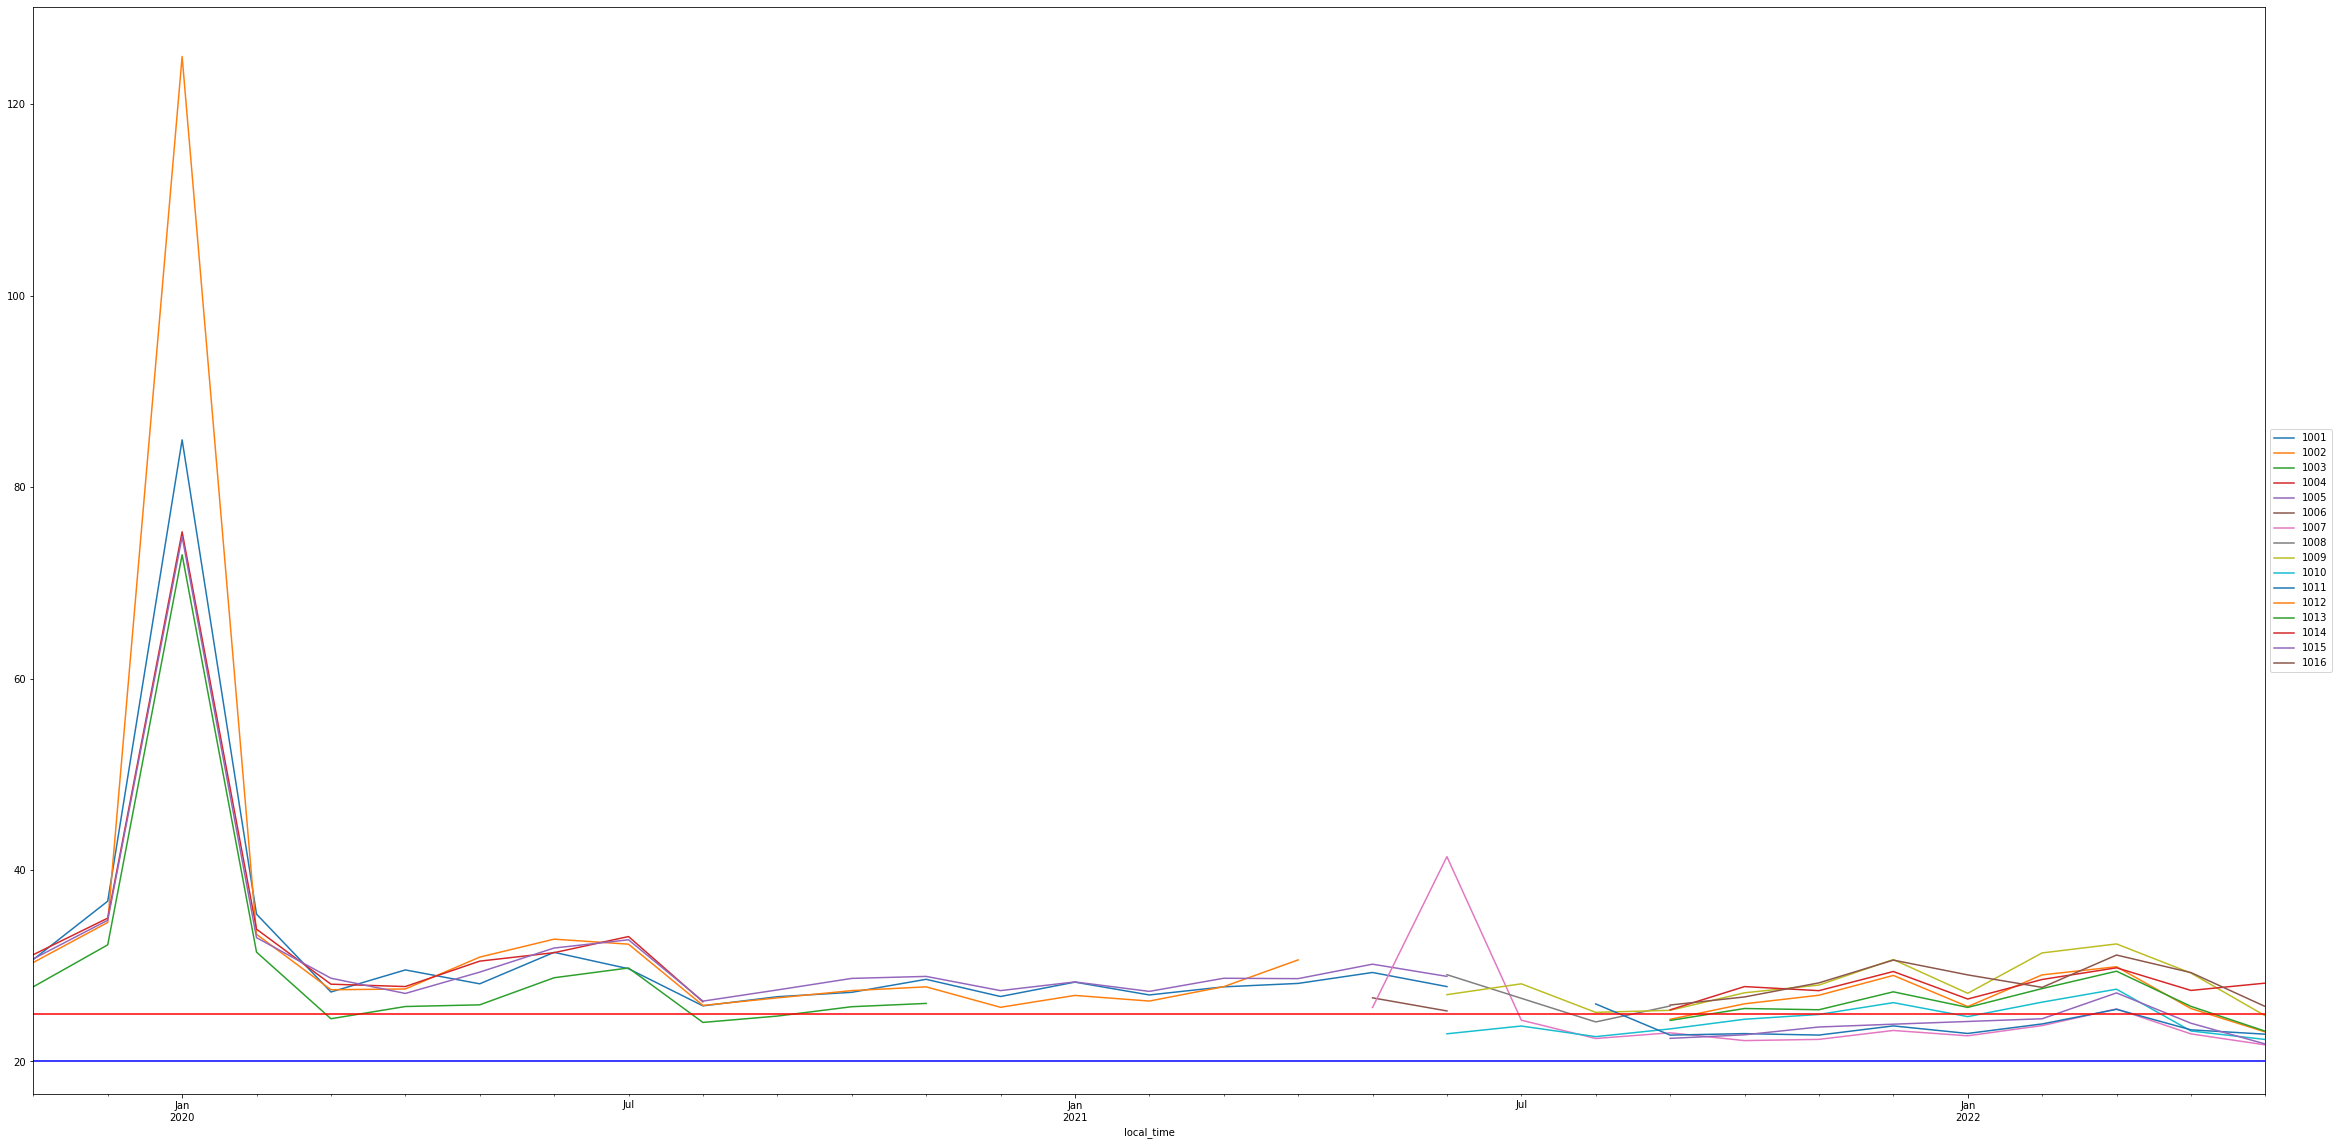

In [9]:
groupbyfields = ['site_id', pd.Grouper(key='local_time', freq='M')]
aggregatebyfields = {'value':['mean']}

# Create new DataFrame grouping the averages of each month since recording first began.
Pm10AllSiteCount = pd.DataFrame(all_pm10_dataset.groupby(groupbyfields).agg(aggregatebyfields))
Pm10AllSiteCount = Pm10AllSiteCount.reset_index()

# Plot this in a timeline graph
fig, ax = plt.subplots(1,1);
Pm10AllSiteCount.groupby(['site_id']).plot(x='local_time', y='value', ax=ax, figsize=(40,20))
plt.legend([v[0] for v in Pm10AllSiteCount.groupby('site_id')['site_id']], loc='center left', bbox_to_anchor=(1, 0.5))

# Add lines representing the national and victorian annual standards.
ax.axhline(y = 25, color = 'r', label='National Annual Standard')
ax.axhline(y = 20, color = 'b', label='Victorian Annual Standard')

### We can see all sites mostly follow a similar trend however based on current and past data there's no reason to expect any significant drops that would reach Victorias annual standard. Of the sites still currently recording data, sites 1009, 1012, 1016 & 1014 are showing the highest averages.

#### Looking purely at the last year of recordings.

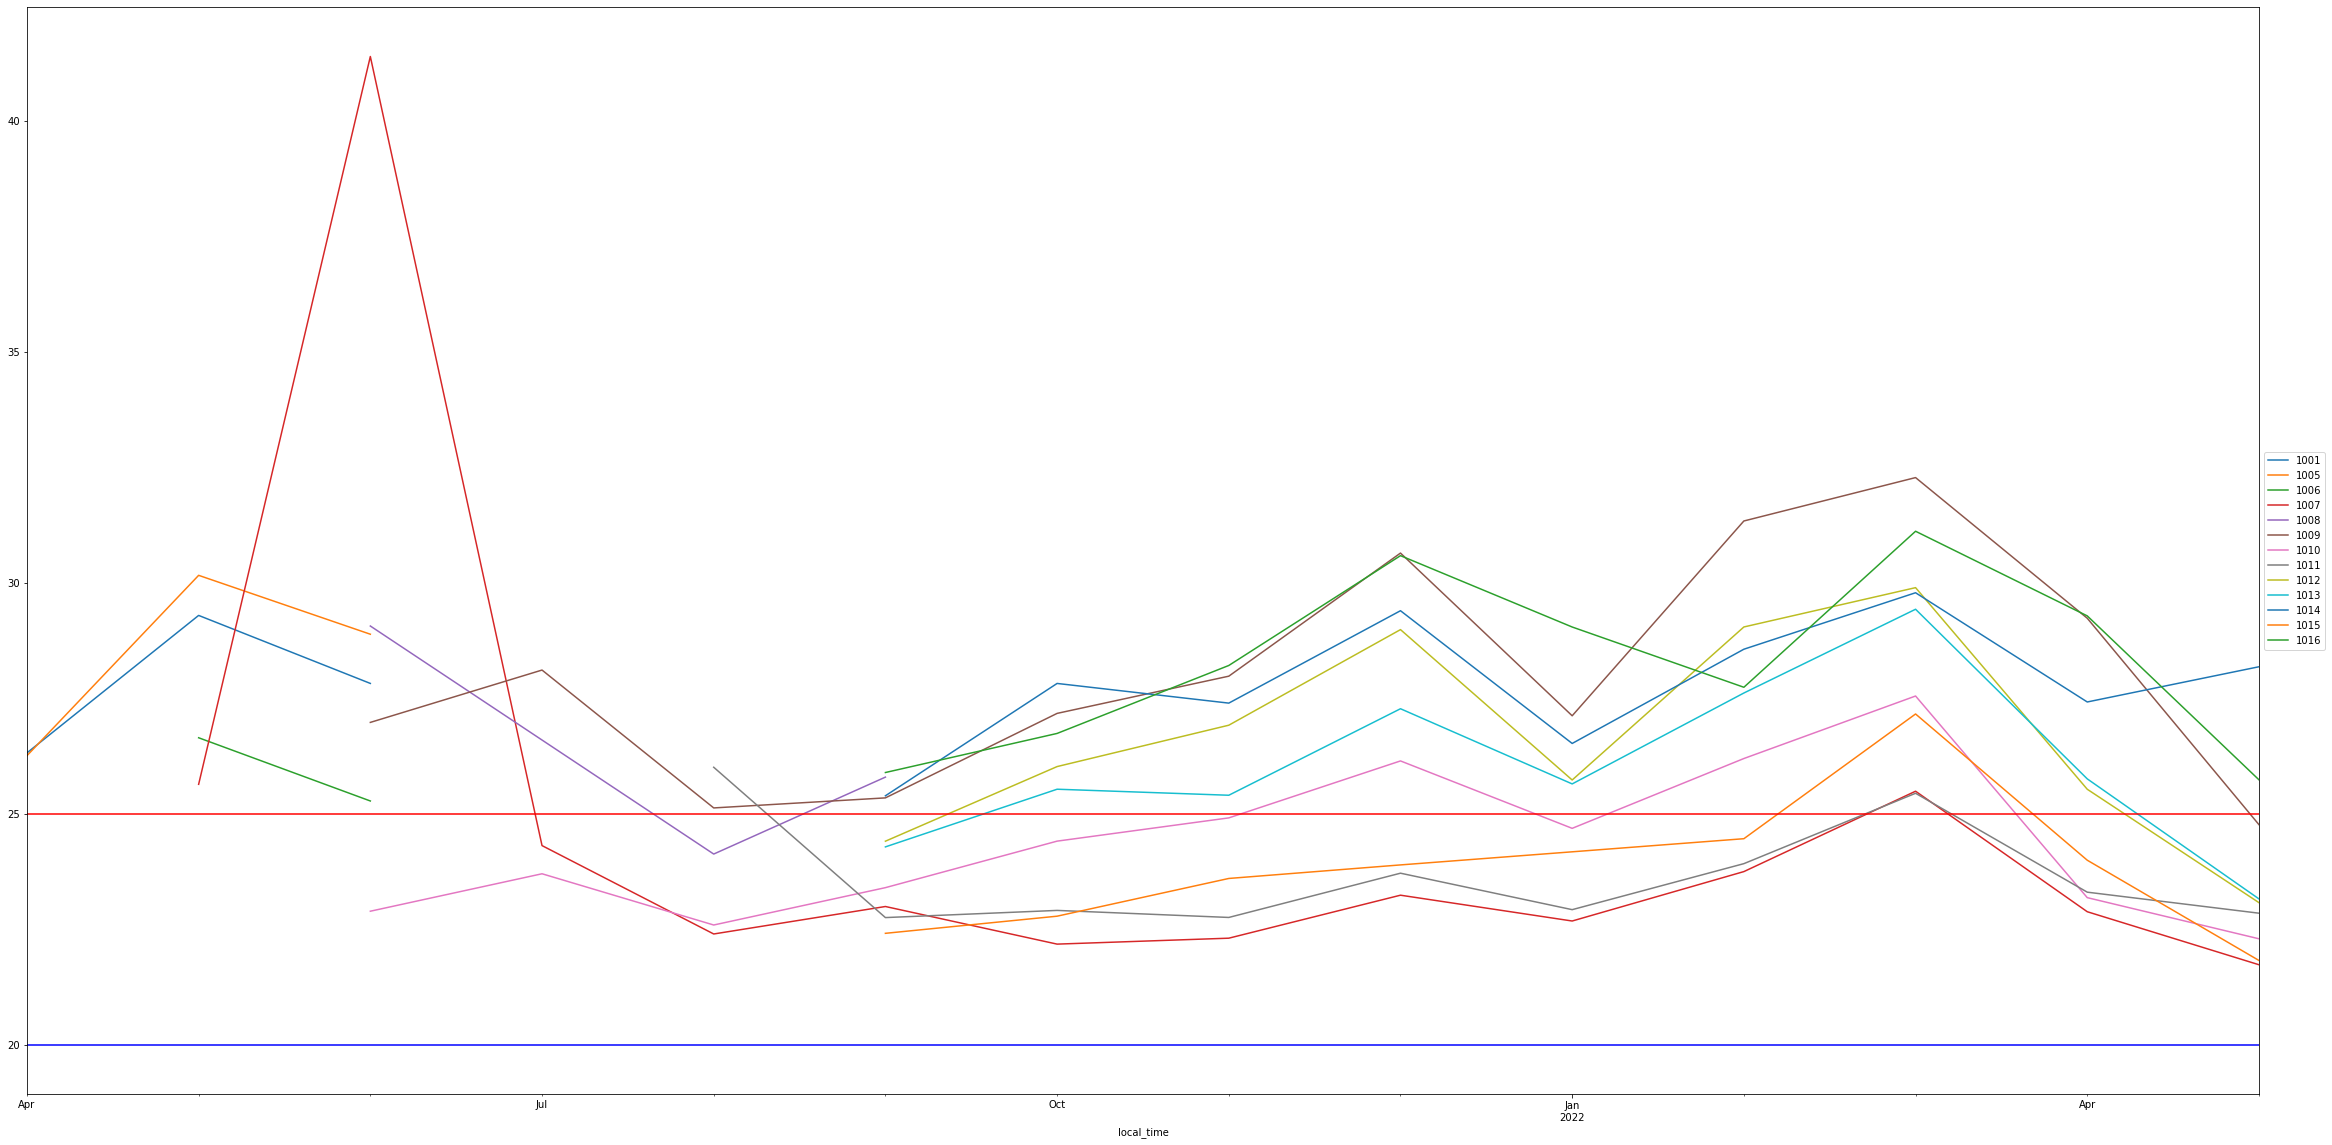

In [10]:
groupbyfields = ['site_id', pd.Grouper(key='local_time', freq='M')]
aggregatebyfields = {'value':['mean']}

# Create new DataFrame grouping the averages of each month over the last year.
Pm10AllSiteCount = pd.DataFrame(pm10_dataset.groupby(groupbyfields).agg(aggregatebyfields))
Pm10AllSiteCount = Pm10AllSiteCount.reset_index()

# Plot this in a timeline graph
fig, ax = plt.subplots(1,1);
Pm10AllSiteCount.groupby(['site_id']).plot(x='local_time', y='value', ax=ax, figsize=(40,20))
plt.legend([v[0] for v in Pm10AllSiteCount.groupby('site_id')['site_id']], loc='center left', bbox_to_anchor=(1, 0.5))

# Add lines representing the national and victorian annual standards.
ax.axhline(y = 25, color = 'r', label='National Annual Standard')
ax.axhline(y = 20, color = 'b', label='Victorian Annual Standard')

### Repeat the process for PM2.5

In [11]:
# Retrieve all hourly rolling 24 hour averages for PM2.5 since April 2021. 
dataresource = client.get(dataset_id, where="type='PM2.5-EPA-1h-NOPK-EPA-24h' AND local_time > '2021-04-11T20:00:00' LIMIT 75000")
pm25_dataset = pd.DataFrame.from_dict(dataresource)
pm25_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55544 entries, 0 to 55543
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              55544 non-null  object
 1   site_id         55544 non-null  object
 2   gateway_hub_id  55544 non-null  object
 3   sensor_id       55544 non-null  object
 4   value           55535 non-null  object
 5   local_time      55544 non-null  object
 6   type            55544 non-null  object
 7   units           55544 non-null  object
dtypes: object(8)
memory usage: 3.4+ MB


In [12]:
# Convert to correct data types
pm25_dataset[['id', 'site_id']] = pm25_dataset[['id', 'site_id']].astype(int)
pm25_dataset[['value']] = pm25_dataset[['value']].astype(float)
pm25_dataset['local_time'] = pd.to_datetime(pm25_dataset['local_time'] )
pm25_dataset = pm25_dataset.convert_dtypes()

pm25_dataset.dtypes

id                         Int32
site_id                    Int32
gateway_hub_id            string
sensor_id                 string
value                    float64
local_time        datetime64[ns]
type                      string
units                     string
dtype: object

In [13]:
groupbyfields = ['site_id']
aggregatebyfields = {'value': ["count", "mean"]}

# Create new DataFrame with value counts and mean values for each site.
Pm25SiteCount = pd.DataFrame(pm25_dataset.groupby(groupbyfields, as_index=False).agg(aggregatebyfields))
Pm25SiteCount

site_id value          
           count      mean
0     1001  1005  8.169851
1     1005  1406  7.336771
2     1006   869  6.336479
3     1007  8125  7.227372
4     1008   665  6.706617
5     1009  7462  7.358791
6     1010  7249  5.866878
7     1011  5879  6.271032
8     1012  5077  7.331869
9     1013  5104  7.370513
10    1014  5259  7.175166
11    1015  3983  6.728797
12    1016  3452  7.123841

#### With the annual average national standard at 8 µg/m3, we can see that whilst most are well below, site_id 1001 does just exceed this. However it has a very small sample size in the last year with recordings stopping around June of 2021.

#### Of those still recording data, 1007, 1009, 1012 & 1013 are the highest averages at this point but still easily meeting the national annual standards.

In [14]:
# Get all hourly 24 hour rolling averages for PM2.5.
dataresource = client.get(dataset_id, where="type='PM2.5-EPA-1h-NOPK-EPA-24h' LIMIT 100000")
all_pm25_dataset = pd.DataFrame.from_dict(dataresource)
all_pm25_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97683 entries, 0 to 97682
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              97683 non-null  object
 1   site_id         97683 non-null  object
 2   gateway_hub_id  97683 non-null  object
 3   sensor_id       97683 non-null  object
 4   value           97671 non-null  object
 5   local_time      97683 non-null  object
 6   type            97683 non-null  object
 7   units           97683 non-null  object
dtypes: object(8)
memory usage: 6.0+ MB


In [15]:
# Convert to correct data types
all_pm25_dataset[['id', 'site_id']] = all_pm25_dataset[['id', 'site_id']].astype(int)
all_pm25_dataset[['value']] = all_pm25_dataset[['value']].astype(float)
all_pm25_dataset['local_time'] = pd.to_datetime(all_pm25_dataset['local_time'] )
all_pm25_dataset = all_pm25_dataset.convert_dtypes()

all_pm25_dataset.dtypes

id                         Int32
site_id                    Int32
gateway_hub_id            string
sensor_id                 string
value                    float64
local_time        datetime64[ns]
type                      string
units                     string
dtype: object

#### Plotting all monthly average recordings for all sites since recordings began to identify potential trends and compare against the annual standard.

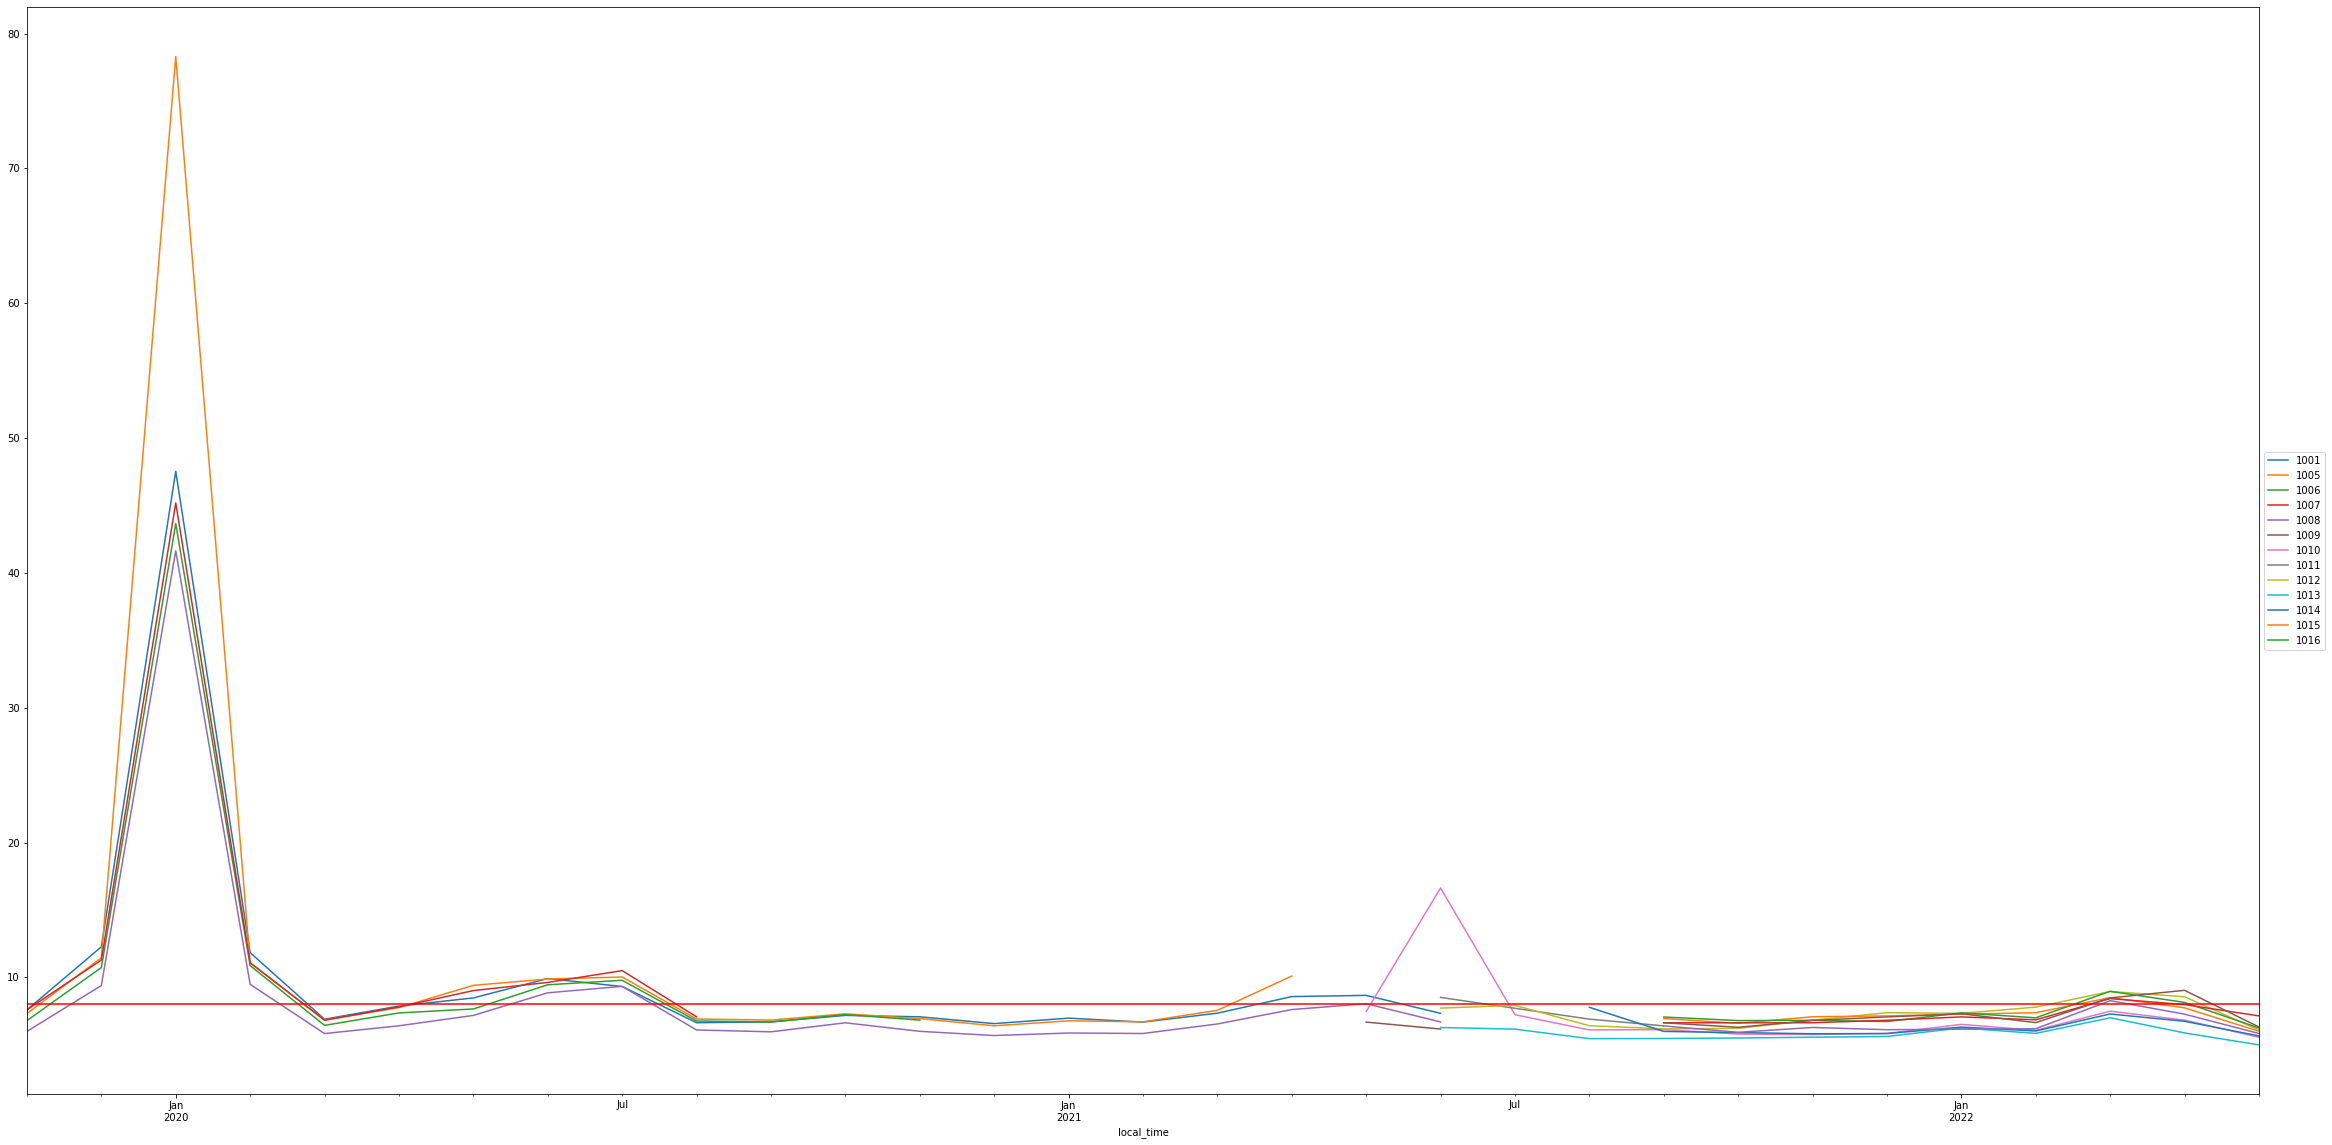

In [16]:
groupbyfields = ['site_id', pd.Grouper(key='local_time', freq='M')]
aggregatebyfields = {'value':['mean']}

# Create new DataFrame grouping the averages of PM 2.5 each month since recording began.
Pm25AllSiteCount = pd.DataFrame(all_pm25_dataset.groupby(groupbyfields).agg(aggregatebyfields))
Pm25AllSiteCount = Pm25AllSiteCount.reset_index()

# Plot this in a timeline graph
fig, ax = plt.subplots(1,1);
Pm25AllSiteCount.groupby(['site_id']).plot(x='local_time', y='value', ax=ax, figsize=(40,20))
plt.legend([v[0] for v in Pm25SiteCount.groupby('site_id')['site_id']], loc='center left', bbox_to_anchor=(1, 0.5))

# Add line representing the national annual standard.
ax.axhline(y = 8, color = 'r', label='Annual Standard')

#### Aside from the unusual spike towards the beginning of recording, we can see no clear trends to indicate at this stage that the PM 2.5 annual averages would be likely exceed the standards.

#### Looking at the past year of readings, we can compare monthly averages to the annual standard to view general progress.

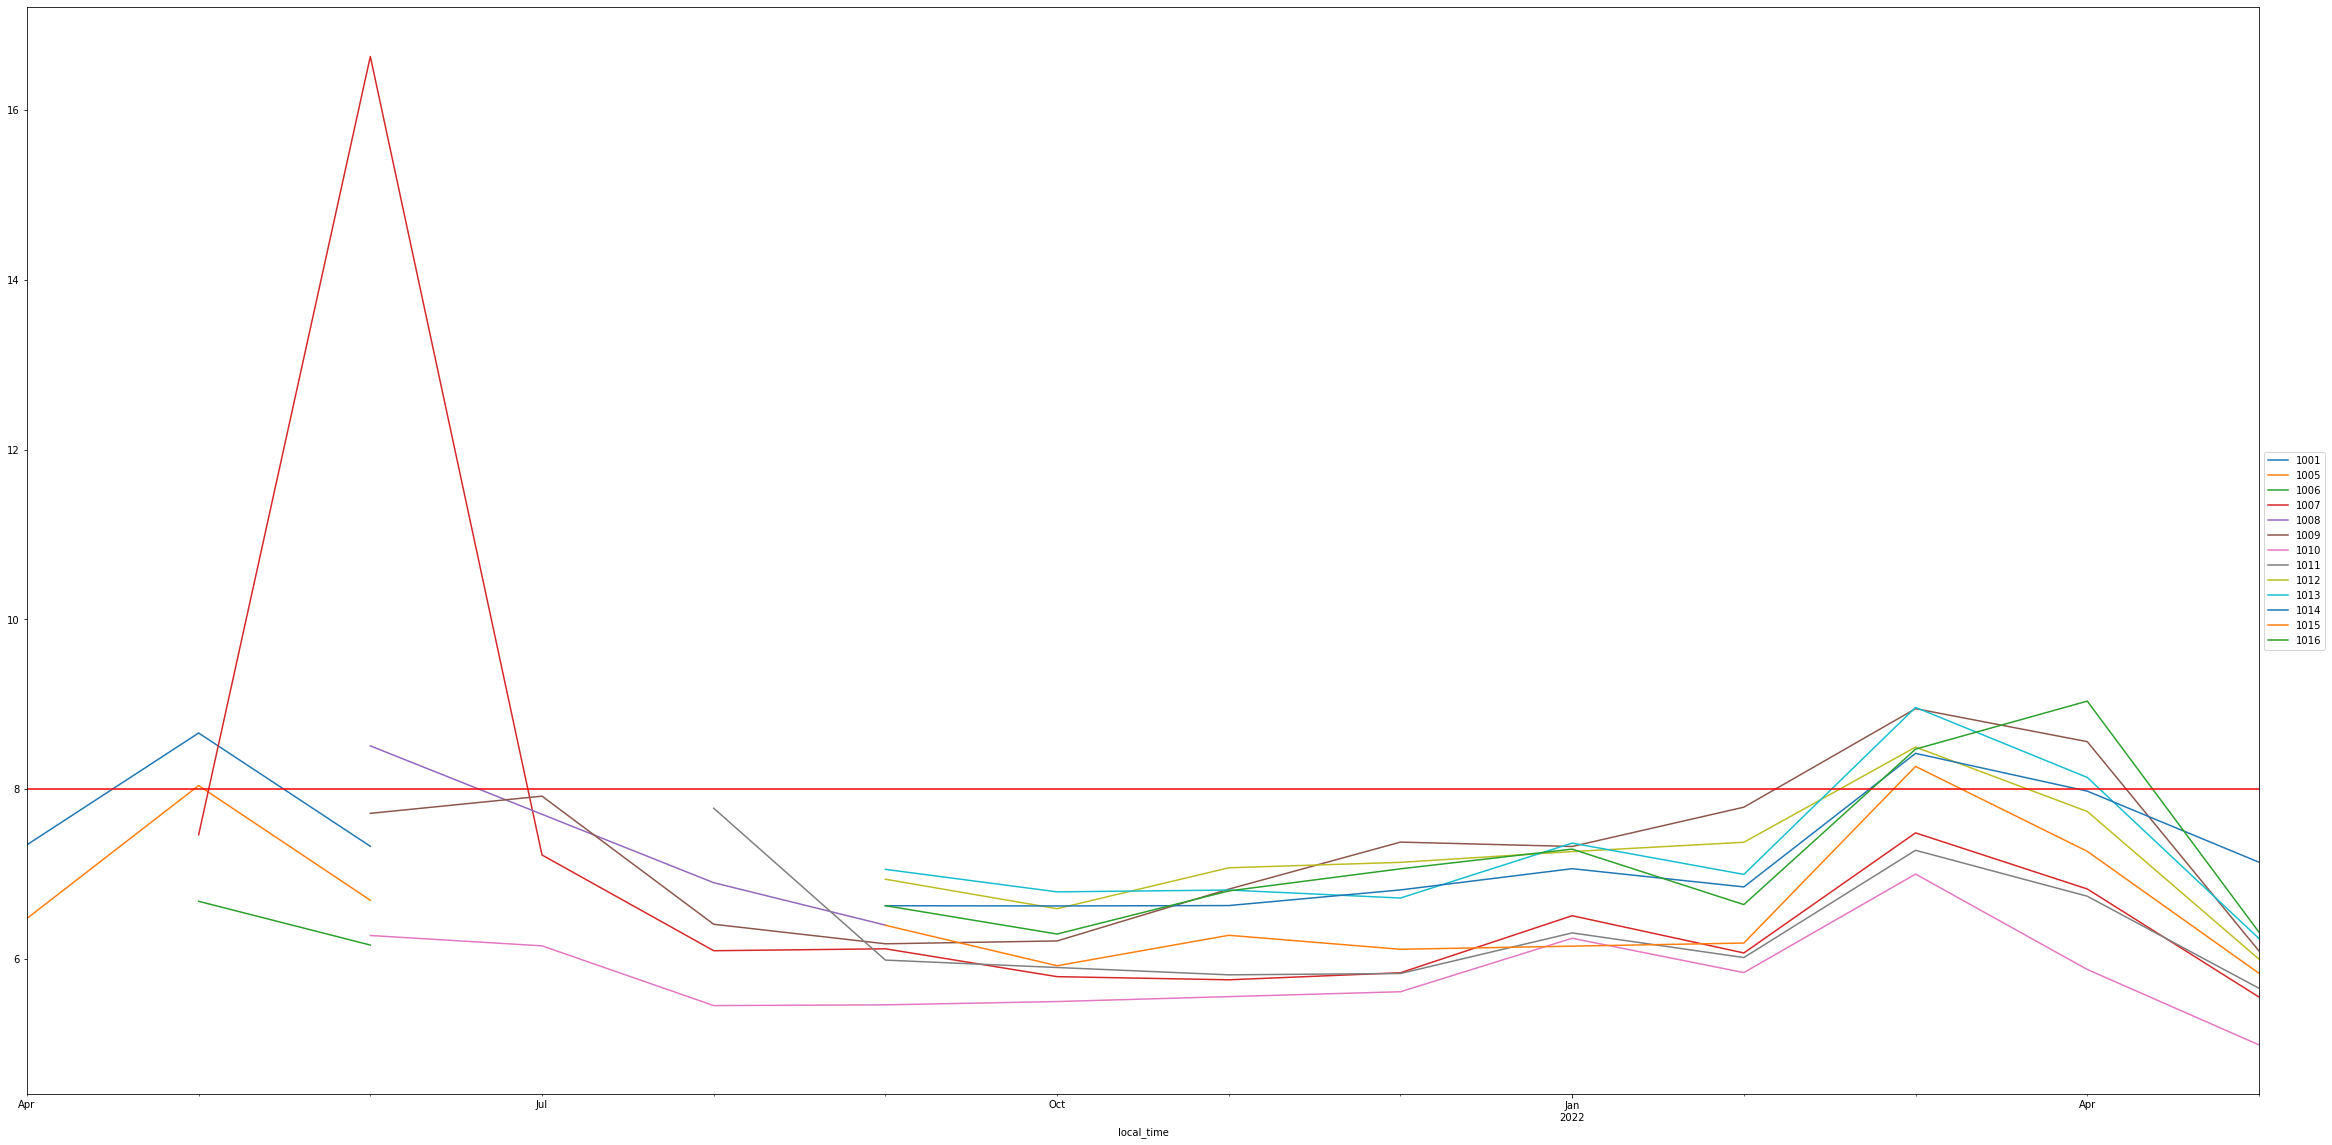

In [17]:
groupbyfields = ['site_id', pd.Grouper(key='local_time', freq='M')]
aggregatebyfields = {'value':['mean']}

# Create new DataFrame grouping the averages of PM 2.5 each month over the last year.
Pm25AllSiteCount = pd.DataFrame(pm25_dataset.groupby(groupbyfields).agg(aggregatebyfields))
Pm25AllSiteCount = Pm25AllSiteCount.reset_index()

# Plot this in a timeline graph
fig, ax = plt.subplots(1,1);
Pm25AllSiteCount.groupby(['site_id']).plot(x='local_time', y='value', ax=ax, figsize=(40,20))
plt.legend([v[0] for v in Pm25SiteCount.groupby('site_id')['site_id']], loc='center left', bbox_to_anchor=(1, 0.5))

# Add line representing the national annual standard.
ax.axhline(y = 8, color = 'r', label='Annual Standard')

### Let's now look at merging our sensor data with the sensors location dataset to use for visualisation.
##### https://data.melbourne.vic.gov.au/Environment/Microclimate-Sensor-Locations/irqv-hjr4

In [18]:
dataset_id = 'irqv-hjr4' # Melbourne Microclimate Sensor Locations
dataresource = client.get(dataset_id)

In [19]:
# Retrieve data from Microclimate Sensor Locations dataset. 
location_dataset = pd.DataFrame.from_dict(dataresource)
location_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   site_id         16 non-null     object
 1   gateway_hub_id  16 non-null     object
 2   description     16 non-null     object
 3   site_status     16 non-null     object
 4   start_reading   16 non-null     object
 5   end_reading     7 non-null      object
 6   longitude       16 non-null     object
 7   latitude        16 non-null     object
 8   location        16 non-null     object
 9   last_data       8 non-null      object
dtypes: object(10)
memory usage: 1.4+ KB


In [20]:
# Set site_id to int for merging
location_dataset[['site_id']] = location_dataset[['site_id']].astype(int)
location_dataset[['longitude', 'latitude']] = location_dataset[['longitude', 'latitude']].astype(float)

In [21]:
# Merging sensor location data with reading data.
pm10 = pd.merge(pm10SiteCount, location_dataset, on='site_id')

In [22]:
# Drop unused columns and convert remaining to string datatypes.
pm10 = pm10.drop(['gateway_hub_id', 'end_reading', 'last_data', 'location'], axis=1)
pm10 = pm10.convert_dtypes()
pm10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 0 to 12
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   site_id        13 non-null     Int64  
 1   value_count    13 non-null     Int64  
 2   value_mean     13 non-null     float64
 3   description    13 non-null     string 
 4   site_status    13 non-null     string 
 5   start_reading  13 non-null     string 
 6   longitude      13 non-null     float64
 7   latitude       13 non-null     float64
dtypes: Int64(2), float64(3), string(3)
memory usage: 962.0 bytes


In [23]:
# Drop retired sensors, remaining sensors running since at least September 2021.
pm10 = pm10[pm10['site_status'] != 'R']
pm10

,site_id,value_count,value_mean,description,site_status,start_reading,longitude,latitude
3,1007,8125,24.748788,Siddeley Street between Spencer Street and Wur...,C,2021-05-20T00:00:00.000,144.951835,-37.822460
5,1009,7462,28.317944,Flinders Lane between Swanston Street and Eliz...,C,2021-06-14T00:00:00.000,144.965705,-37.816868
6,1010,7249,24.638805,"Melbourne Convention Centre Carpark, approxima...",C,2021-06-29T00:00:00.000,144.952222,-37.822500
7,1011,5879,23.524460,"Melbourne Convention Centre Carpark, approxima...",C,2021-07-07T00:00:00.000,144.952222,-37.822222
8,1012,5077,27.228009,Little Collins Street between Exhibition Stree...,C,2021-09-17T00:00:00.000,144.970000,-37.813333
9,1013,5104,26.517966,William Street between Little Lonsdale Street ...,C,2021-09-17T00:00:00.000,144.956389,-37.811944
10,1014,5259,28.007283,Flinders Street between Swanston Street and El...,C,2021-09-17T00:00:00.000,144.967222,-37.817500
11,1015,3983,24.215641,Spring Street between Little Bourke Street and...,C,2021-09-17T00:00:00.000,144.972500,-37.810278
12,1016,3452,28.640498,Lonsdale Street between Elizabeth Street and Q...,C,2021-09-17T00:00:00.000,144.960556,-37.812778


### Visualise the 24 hour average sensor readings data, obtained above, with the sensors location. Circle colour representative of the sensors reading average, below lists a rough guide to the colours in relation to the national and state standards of 25 and 20 respectively.

#### Orange to Red: Above annual standard.
#### Yellow: Above state standard but meeting annual standard.
#### Green: Below both.

In [24]:
# Colour map based on PM10 values.
colormap = cm.LinearColormap(colors=['green','yellow','red'], index=[18, 24, 30], vmin=15, vmax=30,
                             caption='Average PM10 Sensor readings')

# Create base map with style and zoom level.
m = folium.Map(location=[-37.81368709240999, 144.95738102347036], tiles = 'Stamen Toner', zoom_start=15)

# Add sensor locations, popup information and colour based on their mean value.
for _, locat in pm10.iterrows():
    folium.CircleMarker(
        location = [locat['latitude'], locat['longitude']],
        popup = "ID:" + str(locat['site_id']) + " PM10:" + str(round(locat['value_mean'], 2)),
        fill = True,
        color = colormap(locat['value_mean'])
    ).add_to(m)

# Display map
m

### [Insert Tree Coverage & Temperature]